In [1]:
import underworld as uw
import underworld.function as fn
from underworld import UWGeodynamics as GEO
import numpy as np
import math

import os
import h5py   
import matplotlib.pyplot as plt

from underworld import visualisation as vis
u = GEO.UnitRegistry


loaded rc file /opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [9]:
# input parameters
name_bcs = "_FreeSlipBotm"
fdir_output = "op_Zhong2000NMCase1"+name_bcs

xmin_box,xmax_box = -2000,2000   # unit [km]
ymin_box,ymax_box = -3000,0      # unit [km]


x_box = xmax_box-xmin_box
y_box = ymax_box-ymin_box

if uw.mpi.rank == 0:
    x_res,y_res = 400,300   
    npoints = 1000  
    dx = x_box/x_res
    dy = y_box/y_res

else:    
    x_res,y_res = 2400,1200
    npoints = 1200
    dx = x_box/x_res
    dy = y_box/y_res
    
conv_vel = 1.5 * u.centimeter / u.year  # 3.0  * u.centimeter / u.year /2

# dt = 2.5 * u.kiloyear
# Total_Convergence  = 500 *u.kilometer
# Total_Time = (Total_Convergence / conv_vel).to(u.megayear)

#scaling
ref_velocity = 1.5 * u.centimeter / u.year
ref_density = 3300. * u.kilogram / u.meter**3
ref_length = 1000. * u.kilometer  
ref_gravity =  10.0 * u.meter / u.second**2
gravity = 10.0 * u.meter / u.second**2
#ref_vicosity = 1e21 * u.pascal * u.second

T0 = 273.15 * u.degK  # 0 * u.degC
Tz = 1573.15 * u.degK # 1300 * u.degC at litho bottom
# Tz = 1300 + 273.15 + (-ymin_box-ml_thickness)*120

bodyforce = ref_density * ref_gravity
KL = ref_length
Kt = KL / ref_velocity
KM = bodyforce * KL**2 * Kt**2
KT = (Tz - T0)

# ref_velocity = 1. * u.centimeter / u.year
# ref_density = 3300. * u.kilogram / u.meter**3
# ref_length = 1000. * u.kilometer  
# ref_gravity =  10.0 * u.meter / u.second**2
# gravity = 10. * u.meter / u.second**2
# ref_vicosity = 1e21 * u.pascal * u.second

# T0 = 273.15 * u.degK  # 0 * u.degC
# Tz = 1573.15 * u.degK # 1300 * u.degC at litho bottom
# # Tz = 1300 + 273.15 + (-ymin_box-ml_thickness)*120

# bodyforce = ref_density * ref_gravity
# KL = ref_length
# KM = ref_density*KL**3
# Kt = KM/(KL*ref_vicosity)
# KT = (Tz - T0)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

if uw.mpi.rank == 0:
    print('Length, km = ', GEO.dimensionalise(1., u.kilometer))
    print('Time, Myr = ',GEO.dimensionalise(1., u.megayear))
    print('Pressure, MPa = ',GEO.dimensionalise(1., u.megapascal))
    print('Temperature, K = ',GEO.dimensionalise(1., u.degK))
    print('Velocity, cm/yr = ',GEO.dimensionalise(1., u.centimeter / u.year))
    print('Viscosity, Pa S = ',GEO.dimensionalise(1.,u.pascal * u.second))
    
dx_nd = GEO.nd(dx*u.kilometer)
dy_nd = GEO.nd(dy*u.kilometer)

Length, km =  1000.0 kilometer
Time, Myr =  66.66666666666667 megayear
Pressure, MPa =  32999.999999999985 megapascal
Temperature, K =  1300.0 kelvin
Velocity, cm/yr =  1.5 centimeter / year
Viscosity, Pa S =  6.9426719999999984e+25 pascal * second


In [10]:
Model = GEO.Model(elementRes=(x_res, y_res),
                  minCoord=(0. * u.kilometer, ymin_box*u.kilometer),
                  maxCoord=(xmax_box*u.kilometer, ymax_box*u.kilometer),
                  gravity=(0.0, -gravity))
Model.minStrainRate = 1e-18 / u.second

minCoord = tuple([GEO.nd(val) for val in Model.minCoord])
maxCoord = tuple([GEO.nd(val) for val in Model.maxCoord])

meshCopy = uw.mesh.FeMesh_Cartesian(elementType=Model.elementType,
                                    elementRes=Model.elementRes,
                                    minCoord=minCoord,
                                    maxCoord=maxCoord,
                                    periodic=Model.periodic)

	Global element size: 400x300
	Local offset of rank 0: 0x0
	Local range of rank 0: 400x300
In func WeightsCalculator_CalculateAll(): for swarm "BC1DPDVO__swarm"
	done 33% (40000 cells)...
	done 67% (80000 cells)...
	done 100% (120000 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "BC1DPDVO__swarm"
	Global element size: 400x300
	Local offset of rank 0: 0x0
	Local range of rank 0: 400x300


In [11]:
def load_mesh(fdir,meshCopy,step,remesh=False):
    if remesh:
        meshfile = fdir+"mesh-"+ str(step)+".h5"
        meshCopy.load(meshfile)
    else:
        meshfile = fdir+"mesh"+".h5"
        meshCopy.load(meshfile)
    return meshCopy
    
def load_mesh_variable(fdir,step,meshCopy,name,nodeDofCount):
    variableCopy =meshCopy.add_variable(nodeDofCount) 
    variablefile = fdir+ name + str(step) +'.h5'
    variableCopy.load(variablefile)
    return variableCopy

def load_swarm(fdir,meshCopy,step):
    swarmCopy = uw.swarm.Swarm(mesh=meshCopy,particleEscape=True)
    swarmfile = fdir+'swarm-' + str(step)  +'.h5'
    swarmCopy.load(swarmfile)
    return swarmCopy

def load_swarm_variable(fdir,step,swarmCopy,name,dataType,count):
    variableCopy = swarmCopy.add_variable(dataType, count)
    variablefile = fdir+ name + str(step)+'.h5'
    variableCopy.load(variablefile)
    return variableCopy

def load_tracer(fdir,step,name):
    fname = fdir + name + str(step) + ".h5"
    fh5   = h5py.File(fname ,'r')  
    fdata = fh5["data"][()]
    return fdata

In [12]:
def loadtopo_max(fdir,meshCopy,maxstep,dstep):
    depth_max = []
    for step in range(0,maxstep,dstep):
        mesh = load_mesh(fdir,meshCopy,step,remesh=True)
        top = mesh.specialSets[ 'Top_VertexSet'] 
        ycoord = mesh.data[top.data, 1]
        depth_max.append(ycoord.max())  
    return np.array(depth_max)

def loadtopo_max_index(fdir,meshCopy,maxstep,dstep,index,KL):
    depth_max = []
    depth_index = []
    for step in range(0,maxstep,dstep):
        mesh = load_mesh(fdir,meshCopy,step,remesh=True)
        top = mesh.specialSets[ 'Top_VertexSet'] 
        ycoord = mesh.data[top.data, 1] 
        depth_max.append(ycoord.max()) 
        depth_index.append(ycoord[index])
    return np.array(depth_index)*KL,np.array(depth_max)*KL

def loadtopo(fdir,meshCopy,step,KL):
    mesh = load_mesh(fdir,meshCopy,step,remesh=True)
    top = mesh.specialSets[ 'Top_VertexSet'] 
    coords = mesh.data[top.data, :]*KL  
    return coords

In [13]:
def load_mesh_top(fdir,meshCopy,step):
    mesh_tem = load_mesh(fdir,meshCopy,step,remesh=True)
    top = mesh_tem.specialSets['Top_VertexSet']
    return mesh_tem.data[top]

In [17]:
fdir1 = "op_Zhong2000NMCase1_FreeSlipBotm/"
case_name = "Case1_FreeSlipBotm_"

steps = [0,1,5]
dt = 0.1

#coords_topo1 = load_tracer(fdir1,step,"Surf-") 
#x_topo1,y_topo1 = coords_topo1[:,0],coords_topo1[:,1]

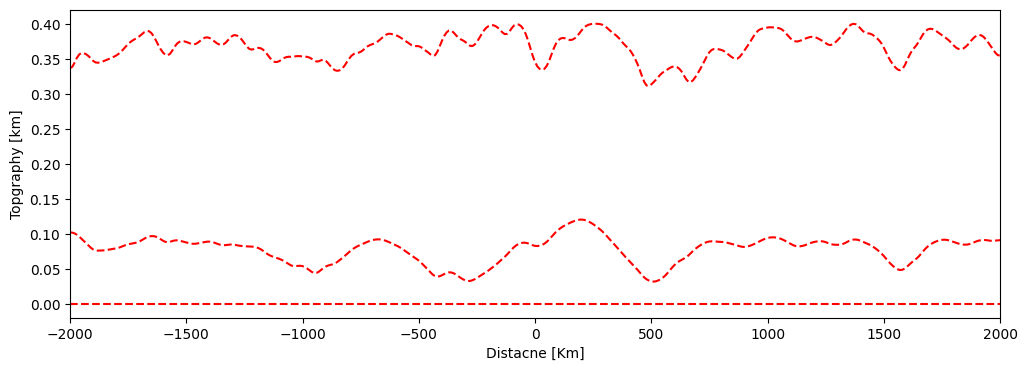

In [18]:
fname = "Topography-" #+str(step)
fig, ax1 = plt.subplots(nrows=1, figsize=(12,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
ax1.set_xlim([xmin_box,xmax_box])
for i,step in enumerate(steps):
    Time = step*dt
    coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    ax1.plot(coords[:,0],coords[:,1],"r--",label="NM_FreeSlipBotm")
    #coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    #ax1.plot(coords[:,0]+600,coords[:,1],"b--",label="NM_LithoBotm")
    #coords = load_mesh_top(fdir1,meshCopy,step)*ref_length.m
    #ax1.plot(coords[:,0],coords[:,1],"b-",label="Vel")
    #ax1.plot(data_x+600,data_surf[:,i+1],"k-",label="Analytic_FreeSurfBotm")
    #ax1.plot(data_x,data_surf[::-1,i+1],"k-")
    #plt.text(0,coords[:,1].max() , str(Time)+" ka", ha='center',fontsize=10, color='k')
#ax1.legend(loc='upper right')
fig.savefig(case_name+"topo")   

In [19]:
fdir = fdir1

meshCopy = load_mesh(fdir,meshCopy,step,remesh=False)
swarmCopy = load_swarm(fdir,meshCopy,step)
materialField = load_swarm_variable(fdir,step,swarmCopy,"materialField-",dataType="int",count=1)
velocityField = load_mesh_variable(fdir,step,meshCopy,"velocityField-",nodeDofCount=2)


HDF5-DIAG: Error detected in HDF5 (1.10.8) MPI-process 0:
  #000: H5F.c line 413 in H5Fopen(): unable to open file
    major: File accessibility
    minor: Unable to open file
  #001: H5Fint.c line 1656 in H5F_open(): unable to open file: time = Sun Sep 17 13:09:44 2023
, name = 'op_Zhong2000NMCase1_FreeSlipBotm/mesh.h5', tent_flags = 0
    major: File accessibility
    minor: Unable to open file
  #002: H5FD.c line 723 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #003: H5FDmpio.c line 1002 in H5FD__mpio_open(): MPI_File_open failed: MPI error string is 'MPI_ERR_NO_SUCH_FILE: no such file or directory'
    major: Internal error (too specific to document in detail)
    minor: Some MPI function failed


RuntimeError: Unspecified error in H5Fopen (return value <0)


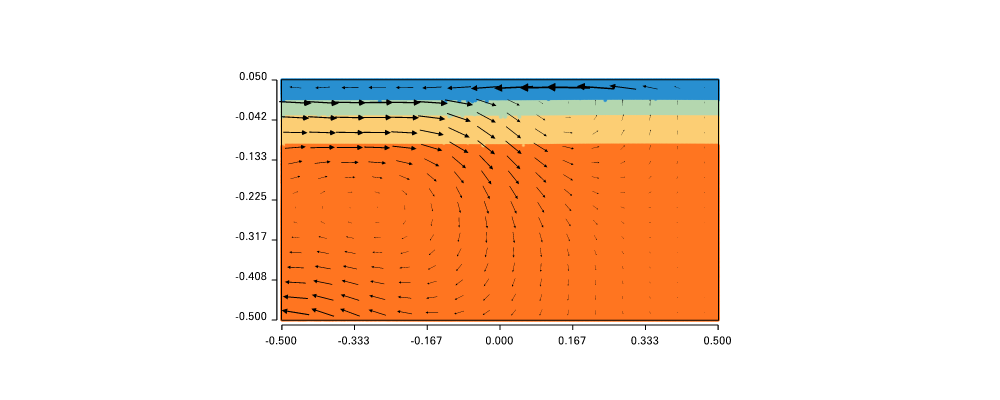

In [15]:
fig_res = (1000,400)

Fig = vis.Figure(resolution=fig_res,rulers=True,margin = 80,rulerticks=7,quality=3,clipmap=False)
#Fig.Points(Model.Moho_tracers, pointSize=4.0)
#Fig.Points(Model.LAB_tracers, pointSize=4.0)
Fig.Points(swarmCopy, materialField,fn_size=4.0,discrete=True,colourBar=False)
Fig.VectorArrows(meshCopy, velocityField) 
Fig.show()
#Fig.save("Model-Ref2Wedge_velbc_"+str(step)+".png")

In [ ]:
air_idx = 1
volume = swarmCopy.particleCoordinates.data 
coords = volume[np.where(materialField.data[:,0]==air_idx)]
x_nd,z_nd = coords[:,0],coords[:,1]
x,z = GEO.dimensionalise(coords[:,0],u.kilometer),GEO.dimensionalise(coords[:,1],u.kilometer)

In [ ]:
fig, ax1 = plt.subplots(nrows=1, figsize=(20,4))
ax1.set(xlabel='Distacne [Km]', ylabel='Topgraphy [km]') 
#ax1.plot(x_topo,y_topo,'k',label = "topo")
ax1.scatter(x,z,c="k")
#ax1.scatter(x_topo,y_topo,c="r")
ax1.scatter(x_topo1,y_topo1,c="y")
#ax1.scatter(x_test,z_test,c="b")
#ax1.scatter(x_test2,y_test2,c="g")
#ax1.legend()